1. 선택적으로 이미지를 사전 정규화합니다. 이것은 조명의 변화에 ​​대한 의존성에 저항하는 기능으로 이어집니다.
2. 수평 및 수직 밝기 변화에 민감한 두 개의 필터로 이미지를 컨볼 루션합니다. 이것은 가장자리, 윤곽 및 질감 정보를 캡처합니다.
3. 이미지를 미리 결정된 크기의 셀로 세분화하고 각 셀 내에서 그라데이션 방향의 히스토그램을 계산합니다.
4. 인접한 셀 블록과 비교하여 각 셀의 히스토그램을 정규화합니다. 이것은 이미지 전반에 걸친 조명 효과를 더욱 억제합니다.
5. 각 셀의 정보에서 1 차원 특징 벡터를 생성합니다

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

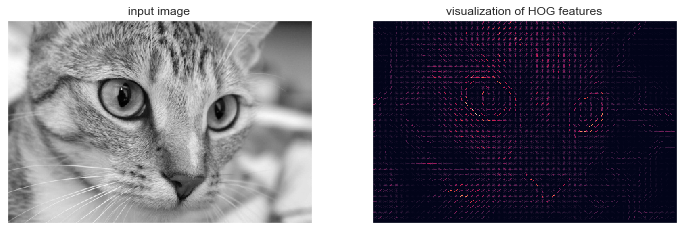

In [5]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [ ]:
1. 긍정 훈련 표본을 구성하기 위해 얼굴 이미지 섬네일을 구한다.
2. 부정 훈련 표본을 구성하기 위해 얼굴이 아닌 이미지 섬네일을 구한다.
3. 이 훈련 표본으로부터 HOG 특징을 추출
4. 이 표본에 선형 SVM 분류기를 훈련
5. 알려지지않은 이미지에 대해서는 이미지에 슬라이딩 윈도우를 전달하고 그 모델을 사용해 윈도우가 얼굴을 포함하고 있는지 아닌지 평가
6. 얼굴 인식이 겹치면 하나의 윈도우에 결합


In [6]:
# 1. 긍정 훈련 표본을 구성하기 위해 얼굴 이미지 섬네일을 구한다.
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [8]:
# 2. 부정 훈련 표본을 구성하기 위해 얼굴이 아닌 이미지 섬네일을 구한다.
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [9]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

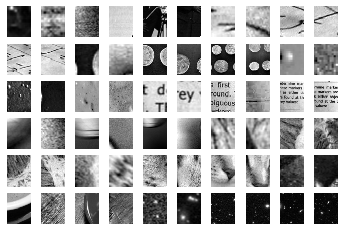

In [10]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')